### This code is a new branch where CSAT data that use is after analysis (Taking Out The Unnecessary Data)

In [1]:
import gspread
import pandas as pd
from datetime import date
from google.oauth2.service_account import Credentials

## Pipeline A

In [2]:
SERVICE_ACCOUNT_FILE = '../../key/credentials.json'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets',
          'https://www.googleapis.com/auth/drive']

creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

sheet = client.open("Chatbot Ops Report").worksheet("[CSAT After Take Out]")
data = sheet.get_all_values()

df = pd.DataFrame(data[1:], columns=data[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   w                  614 non-null    object
 1   Total Good Survey  614 non-null    object
 2   Total Bad Survey   614 non-null    object
 3   Total Responden    614 non-null    object
 4   Total Rating       614 non-null    object
 5   CSAT [Before]      614 non-null    object
 6   CSAT [After]       614 non-null    object
 7   %                  614 non-null    object
 8                      614 non-null    object
 9   Date               614 non-null    object
 10  Total Good Survey  614 non-null    object
 11  Total Bad Survey   614 non-null    object
 12  Total Responden    614 non-null    object
 13  Total Rating       614 non-null    object
 14  CSAT               614 non-null    object
dtypes: object(15)
memory usage: 72.1+ KB


In [4]:
# Copying the DF
df_before = (
    df.copy()
    .iloc[:, [0,3,4,5]]
    .drop_duplicates(subset='Date')
)

df_after = (
    df.copy()
    .iloc[:, [9,12,13,6]]
    .drop_duplicates(subset='Date')
)

# Changing the Date data type
df_before['Date'] = pd.to_datetime(
    df_before['Date'], format='%d-%b-%Y', errors='coerce'
)

df_after['Date'] = pd.to_datetime(
    df_after['Date'], format='%d-%b-%Y', errors='coerce'
)

# dropping NA
df_before = df_before.dropna(subset=['Date'])
df_after = df_after.dropna(subset=['Date'])

df_before.info()

KeyError: Index(['Date'], dtype='object')

### Feature Engineering on data CSAT After Take Out

In [ ]:
import matplotlib.pyplot as plt

df_merge = df_before.merge(df_after, on='Date', how='left', suffixes=('_Before', '_After'))

In [ ]:
# Data Type
cols = ['Total Responden_After', 'Total Rating_After', 'CSAT [After]']
df_merge[cols] = df_merge[cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
# Filling NA with rolling window method
missing_mask = df_merge['CSAT [After]'].isna()

df_merge['CSAT_Imputed'] = df_merge['CSAT [After]'].fillna(
    df_merge['CSAT [After]'].rolling(window=7, min_periods=1, center=True).mean()
)

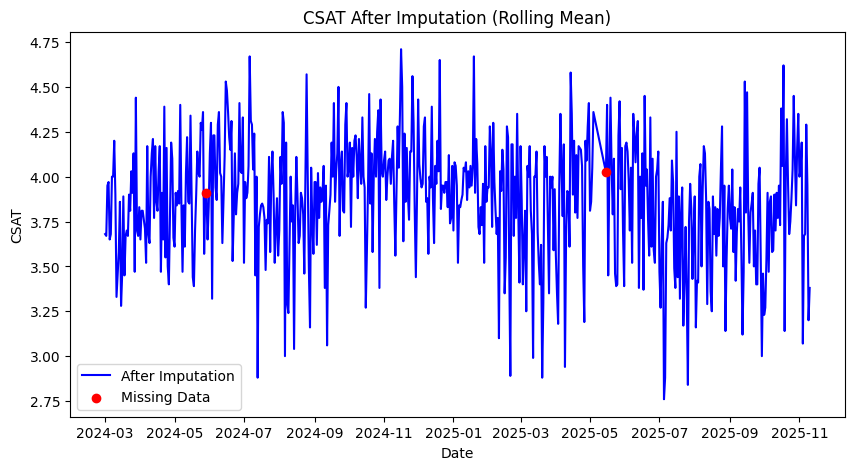

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_merge['Date'], df_merge['CSAT_Imputed'], label='After Imputation', color='blue')

plt.scatter(df_merge.loc[missing_mask, 'Date'],
            df_merge.loc[missing_mask, 'CSAT_Imputed'],
            color='red', label='Missing Data', zorder=5)

plt.title('CSAT After Imputation (Rolling Mean)')
plt.xlabel('Date')
plt.ylabel('CSAT')
plt.legend()
plt.show()

In [ ]:
# Applying rolled window method to all relevant columns

cols_rolled = ['Total Responden_After', 'Total Rating_After', 'CSAT [After]']

df_merge[cols_rolled] = df_merge[cols_rolled].fillna(
    df_merge[cols_rolled].rolling(window=7, min_periods=1, center=True).mean()
)

df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    610 non-null    datetime64[ns]
 1   Total Responden_Before  610 non-null    object        
 2   Total Rating_Before     610 non-null    object        
 3   CSAT [Before]           610 non-null    object        
 4   Total Responden_After   610 non-null    float64       
 5   Total Rating_After      610 non-null    float64       
 6   CSAT [After]            610 non-null    float64       
 7   CSAT_Imputed            610 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 38.3+ KB


In [ ]:
df_before = df_merge.iloc[:, [0,1,2,3]].rename(columns={
    'Total Responden_Before': 'Total Responden',
    'Total Rating_Before': 'Total Rating', 
    }
)

df_after = df_merge.iloc[:, [0,4,5,6]].rename(columns={
    'Total Responden_After': 'Total Responden',
    'Total Rating_After': 'Total Rating'
    }
)

if df_before['CSAT [Before]'].count() == df_after['CSAT [After]'].count():
    print("it's same.\n")
else:
    print("something wrong, I can feel it.")


for i in [df_before, df_after]:
    i.info()
    print('')

it's same.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             610 non-null    datetime64[ns]
 1   Total Responden  610 non-null    object        
 2   Total Rating     610 non-null    object        
 3   CSAT [Before]    610 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 19.2+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             610 non-null    datetime64[ns]
 1   Total Responden  610 non-null    float64       
 2   Total Rating     610 non-null    float64       
 3   CSAT [After]     610 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 19.2 KB



### Exporting to CSV

In [ ]:
# export to csv
df_before.to_csv('../../dataset_kula/csat_before_takeout.csv')
df_after.to_csv('../../dataset_kula/csat_after_takeout.csv')

In [ ]:
df_after

,Date,Total Responden,Total Rating,CSAT [After]
0,2024-03-01,50.0,184.0,3.68
1,2024-03-02,42.0,154.0,3.67
2,2024-03-03,38.0,150.0,3.95
3,2024-03-04,37.0,147.0,3.97
4,2024-03-05,51.0,186.0,3.65
...,...,...,...,...
605,2025-11-06,25.0,92.0,3.68
606,2025-11-07,31.0,133.0,4.29
607,2025-11-08,22.0,87.0,3.95
608,2025-11-09,15.0,48.0,3.20


: 